# Fine-Tunning




<figure>
    <center>
        <img src="attachments/fine_tunning.png"  style="width:750px;" >
    </center>
</figure>

# ROC - Turning probability into classifications

[ROC and AUC, Clearly Explained!](https://www.youtube.com/watch?v=4jRBRDbJemM)

In [4]:
%load_ext autoreload
%autoreload all
%matplotlib inline

In [5]:
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    precision_recall_curve,
    roc_curve,
)

from luna16 import datasets, dto, utils

device = utils.get_device()

In [22]:
luna_dataset = datasets.MalignantLunaDataset(
    validation_stride=10,
    train=False,
    ratio=dto.LunaMalignantRatio(benign=1, malignant=1, not_module=1),
)


n_malignant = len(luna_dataset.is_malignant_candidates)
# n_not_malignant = n_malignant
n_not_malignant = len(luna_dataset.not_malignant_candidates)
shortened_not_malignant_candidates = luna_dataset.not_malignant_candidates[
    :n_not_malignant
]
nodules = shortened_not_malignant_candidates + luna_dataset.is_malignant_candidates
nodules_malignancy_mask = torch.tensor([n.is_malignant for n in nodules])
diameters = torch.tensor([n.diameter_mm for n in nodules])

len(nodules_malignancy_mask), n_malignant, n_not_malignant

[2024-06-19 15:01:45,889][INFO]: MalignantLunaDataset(len=17606, training_len=None, positive_len=40, negative_len=17566, train=False, validation_stride=10)


(17606, 23, 17583)

In [23]:
luna_dataset.is_malignant_candidates

[CandidateMalignancyInfo(series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114', is_nodule=True, is_annotated=True, is_malignant=True, diameter_mm=19.65387738, center=CoordinatesXYZ(x=56.39315434, y=67.68008675, z=-64.67445255)),
 CandidateMalignancyInfo(series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405', is_nodule=True, is_annotated=True, is_malignant=True, diameter_mm=18.54514997, center=CoordinatesXYZ(x=2.441546798, y=172.46488119999998, z=-405.4937318)),
 CandidateMalignancyInfo(series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405', is_nodule=True, is_annotated=True, is_malignant=True, diameter_mm=18.20857028, center=CoordinatesXYZ(x=90.93171321, y=149.0272657, z=-426.5447146000001)),
 CandidateMalignancyInfo(series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748', is_nodule=True, is_annotated=True, is_malignant=True, diameter_mm=17.75323185, center=CoordinatesXYZ(x=94.63511683, y=-17.37

In [24]:
threshold = torch.linspace(start=diameters.max(), end=diameters.min(), steps=100)
threshold[:, None].shape, diameters.max(), diameters.min()

(torch.Size([100, 1]), tensor(19.6539), tensor(0.))

In [25]:
# Using any_tensor[None] is the same as unsign unsqueeze on zeroth dimension
unsqueezed_explicit = diameters.unsqueeze(0)
unsqueezed_implicit = diameters[None]

diameters.shape, unsqueezed_explicit.shape, unsqueezed_implicit.shape

(torch.Size([17606]), torch.Size([1, 17606]), torch.Size([1, 17606]))

In [26]:
# Diameters must be unsquezed to make it comparable with thresholds
# Comparation shapes are [1, 17_659] to [100, 1]
threshold_predictions = diameters[None] >= threshold[:, None]

# Compare every diameter with n number of threshold.
# predictions tensor has 100 bool element for every diameter entry
# with value either True if diameter is greater that this threshold
# or false of it is not.
threshold_predictions.shape

torch.Size([100, 17606])

## False Positive Rate
Other names: False positive rate (FPR), probability of false alarm, fall-out type 1 error

$$
FPR = \frac{False \ Positives}{All \ Negatives} = \frac{FP}{FP + TN}
$$


## True Positive Rate
Other names: True positive rate (TPR), recall, sensitivity (SEN), probability of detection, hit rate, power
$$
TPR = \frac{True \ Positives}{All \ positives} = \frac{TP}{TP + FN}
$$

## Positive predictive value 
Other names: Precision

$$
PPV = \frac{True \ Positives}{Predicted \ Positives} = \frac{TP}{TP + FP} 
$$

In [27]:
# Make intersection for prediction (is malignant base on its size) and compare it to ground truth.
# Then sum True values getting 100 number representing true positives for every threshold.
true_positives_by_threshold = (
    threshold_predictions & nodules_malignancy_mask[None]
).sum(1).float() / n_malignant

# Make intersection for prediction (is malignant base on its size) and compare it to ground truth.
# Then sum False values getting 100 number representing false positives for every threshold.
false_positives_by_threshold = (
    threshold_predictions & ~nodules_malignancy_mask[None]
).sum(1).float() / n_not_malignant

precision_by_threshold = (threshold_predictions & nodules_malignancy_mask[None]).sum(
    1
).float() / threshold_predictions.sum(dim=1).float()

(
    true_positives_by_threshold.shape,
    false_positives_by_threshold.shape,
    precision_by_threshold.shape,
)

(torch.Size([100]), torch.Size([100]), torch.Size([100]))

In [28]:
# To compute the area under this curve, we use numeric integration by the trapezoidal rule
# (https://en.wikipedia.org/wiki/Trapezoidal_rule), where we multiply the average TPRs
# (on the Y-axis) between two points by the difference of the two FPRs (on the X-axis)
# the area of trapezoids between two points of the graph. Then we sum the area of the trapezoids
true_positive_diameter_average = (
    true_positives_by_threshold[1:] + true_positives_by_threshold[:-1]
) / 2
false_positive_diameter_difference = (
    false_positives_by_threshold[1:] - false_positives_by_threshold[:-1]
)
auc_diameters = (
    false_positive_diameter_difference * true_positive_diameter_average
).sum()

(
    auc_diameters,
    true_positive_diameter_average.shape,
    false_positive_diameter_difference.shape,
)

(tensor(0.9999), torch.Size([99]), torch.Size([99]))

In [29]:
precision_diameter_difference = precision_by_threshold[:-1] - precision_by_threshold[1:]
auc_diameters_precision = (
    precision_diameter_difference * true_positive_diameter_average
).sum()

auc_diameters_precision

tensor(0.9175)

In [30]:
true_positive_auc_fill = torch.cat(
    (true_positives_by_threshold, torch.tensor([true_positives_by_threshold.min()]))
)

false_positive_auc_fill = torch.cat(
    (false_positives_by_threshold, torch.tensor([false_positives_by_threshold.max()]))
)

In [31]:
precision_auc_fill = torch.cat(
    (precision_by_threshold, torch.tensor([precision_by_threshold.min()]))
)
precision_auc_fill

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9167, 0.9167,
        0.9231, 0.9231, 0.9286, 0.9286, 0.9286, 0.9286, 0.9286, 0.9286, 0.9286,
        0.9333, 0.9333, 0.9333, 0.9333, 0.9333, 0.9333, 0.8750, 0.8235, 0.8421,
        0.8500, 0.8500, 0.8500, 0.8571, 0.8750, 0.8750, 0.8750, 0.8750, 0.8750,
        0.8077, 0.8077, 0.7500, 0.7333, 0.7097, 0.6765, 0.6571, 0.6389, 0.6389,
        0.6389, 0.6389, 0.6216, 0.6216, 0.6053, 0.5897, 0.5750, 0.5750, 0.5750,
        0.5750, 0.5750, 0.5750, 0.5750, 0.5750, 0.5750, 0.5750, 0.5750, 0.5750,
        0.5750, 0.5750, 0.5750, 0.5750, 0.5750, 0.5750, 0.5750, 0.5750, 0.5750,
        0.0013, 0.0013])

In [32]:
for i in range(threshold.shape[0]):
    print(
        i, threshold[i], false_positives_by_threshold[i], true_positives_by_threshold[i]
    )

0 tensor(19.6539) tensor(0.) tensor(0.0435)
1 tensor(19.4554) tensor(0.) tensor(0.0435)
2 tensor(19.2568) tensor(0.) tensor(0.0435)
3 tensor(19.0583) tensor(0.) tensor(0.0435)
4 tensor(18.8598) tensor(0.) tensor(0.0435)
5 tensor(18.6613) tensor(0.) tensor(0.0435)
6 tensor(18.4627) tensor(0.) tensor(0.0870)
7 tensor(18.2642) tensor(0.) tensor(0.0870)
8 tensor(18.0657) tensor(0.) tensor(0.1304)
9 tensor(17.8672) tensor(0.) tensor(0.1304)
10 tensor(17.6686) tensor(0.) tensor(0.1739)
11 tensor(17.4701) tensor(0.) tensor(0.2174)
12 tensor(17.2716) tensor(0.) tensor(0.2174)
13 tensor(17.0731) tensor(0.) tensor(0.2174)
14 tensor(16.8745) tensor(0.) tensor(0.2174)
15 tensor(16.6760) tensor(0.) tensor(0.2174)
16 tensor(16.4775) tensor(0.) tensor(0.2174)
17 tensor(16.2790) tensor(0.) tensor(0.2609)
18 tensor(16.0804) tensor(0.) tensor(0.2609)
19 tensor(15.8819) tensor(0.) tensor(0.3043)
20 tensor(15.6834) tensor(0.) tensor(0.3043)
21 tensor(15.4849) tensor(0.) tensor(0.3043)
22 tensor(15.2863) t

Diameter: 9.73, x: 0.93, y: 0.61
Diameter: 7.74, x: 0.88, y: 0.91


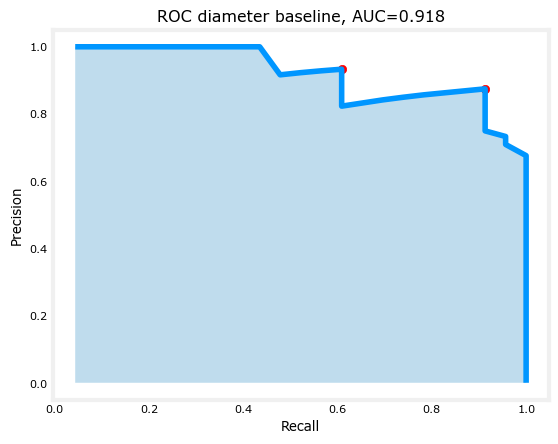

In [33]:
fig, ax = plt.subplots()
# Add two threshold as red dots to plot
for i in [50, 60]:
    ax.scatter(true_positives_by_threshold[i], precision_by_threshold[i], color="red")
    print(
        f"Diameter: {round(threshold[i].item(), 2)}, "
        f"x: {round(precision_by_threshold[i].item(), 2)}, "
        f"y: {round(true_positives_by_threshold[i].item(), 2)}"
    )
# Add fill representing AUC - Area Under the Curve
ax.fill(true_positive_auc_fill, precision_auc_fill, facecolor="#0077bb", alpha=0.25)
# Plot ROC - Receiver Operating Characteristic Curve
ax.plot(
    true_positives_by_threshold,
    precision_by_threshold,
    label=f"diameter baseline, AUC={auc_diameters_precision:.3f}",
)
# Assign metadata to axis
ax.set_title(f"ROC diameter baseline, AUC={auc_diameters_precision:.3f}")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
fig.savefig("roc_diameter_baseline.png")

Diameter: 7.35, x: 0.0, y: 0.91
Diameter: 2.18, x: 0.0, y: 1.0


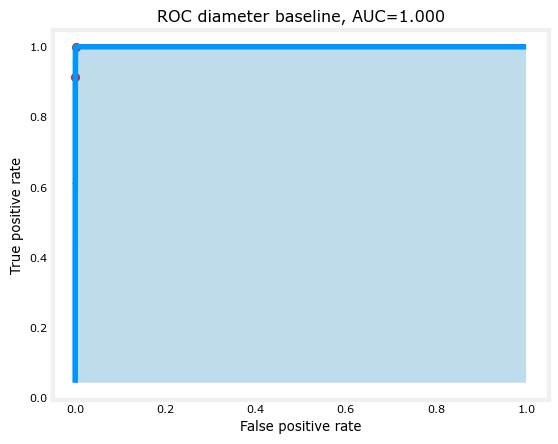

In [34]:
fig, ax = plt.subplots()
# Add two threshold as red dots to plot
for i in [62, 88]:
    ax.scatter(
        false_positives_by_threshold[i], true_positives_by_threshold[i], color="red"
    )
    print(
        f"Diameter: {round(threshold[i].item(), 2)}, "
        f"x: {round(false_positives_by_threshold[i].item(), 2)}, "
        f"y: {round(true_positives_by_threshold[i].item(), 2)}"
    )
# Add fill representing AUC - Area Under the Curve
ax.fill(
    false_positive_auc_fill, true_positive_auc_fill, facecolor="#0077bb", alpha=0.25
)
# Plot ROC - Receiver Operating Characteristic Curve
ax.plot(
    false_positives_by_threshold,
    true_positives_by_threshold,
    label=f"diameter baseline, AUC={auc_diameters:.3f}",
)
# Assign metadata to axis
ax.set_title(f"ROC diameter baseline, AUC={auc_diameters:.3f}")
ax.set_ylabel("True positive rate")
ax.set_xlabel("False positive rate")
fig.savefig("roc_diameter_baseline.png")

In [49]:
y_true = torch.cat([nodules_malignancy_mask for _ in range(100)])
probas_pred = threshold_predictions.flatten()

y_true.shape, probas_pred.shape

(torch.Size([1760600]), torch.Size([1760600]))

In [50]:
y_true

tensor([False, False, False,  ...,  True,  True,  True])

[2024-06-19 15:19:25,403][WARNING]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


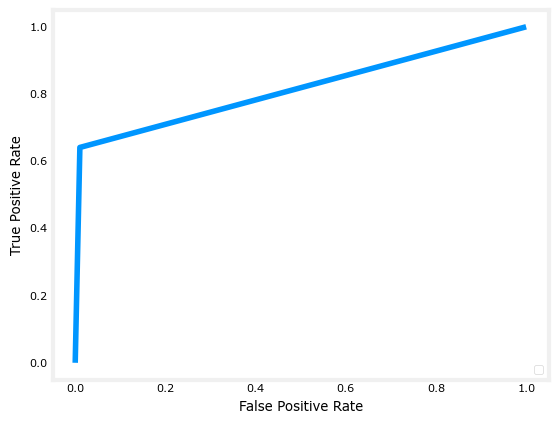

In [51]:
fpr, tpr, _ = roc_curve(y_true=y_true, y_score=probas_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

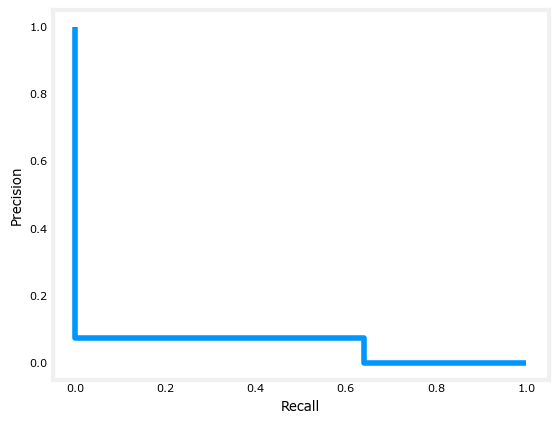

In [46]:
precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=probas_pred)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()

# Comparing Fine-tuned model to baseline

In [2]:
from torch.utils import data as data_utils

from luna16 import datasets, models, training

In [10]:
state_name = "malignant_2024-06-19T14:06:04.642720.best.state"

saver = training.ModelSaver(model_name="malignant")
model = saver.load_model(
    n_excluded_blocks=2, model=models.LunaModel(), state_name=state_name
)
model.to(device)
model.eval()

[2024-06-19 14:40:23,665][INFO]: Fine-tuning from /Users/macbook/Projects/ml/models/luna/malignant/malignant_2024-06-19T14:06:04.642720.best.state, blocks: block4, head_linear


LunaModel(
  (tail_batchnorm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): LunaBlock(
    (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): LunaBlock(
    (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): LunaBlock(
    (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(32, 32, kernel_siz

In [61]:
luna_dataset = datasets.MalignantLunaDataset(
    validation_stride=10,
    train=False,
    ratio=dto.LunaMalignantRatio(malignant=1, benign=1, not_module=1),
    # training_length=1000,
)
luna_dataloader = data_utils.DataLoader(luna_dataset, batch_size=32, num_workers=4)

[2024-06-19 16:17:55,159][INFO]: MalignantLunaDataset(len=17606, training_len=None, positive_len=40, negative_len=17566, train=False, validation_stride=10)


In [62]:
_predictions: list[torch.dtype] = []
_truths: list[bool] = []
for candidates, labels, _, _ in luna_dataloader:
    candidates: torch.Tensor = candidates.to(device)
    truth = labels[:, 1] > 0
    truth_positive: list[bool] = (truth).tolist()
    _truths += truth
    with torch.no_grad():
        _, prediction = model(candidates)
        prediction_positive: list[torch.dtype] = prediction[:, 1].tolist()
        _predictions += prediction_positive

model_predictions = torch.tensor(_predictions)
model_truths = torch.tensor(_truths)

len(model_predictions), model_predictions.dtype, len(model_truths), truth.dtype

(17606, torch.float32, 17606, torch.bool)

[2024-06-19 16:26:19,118][WARNING]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


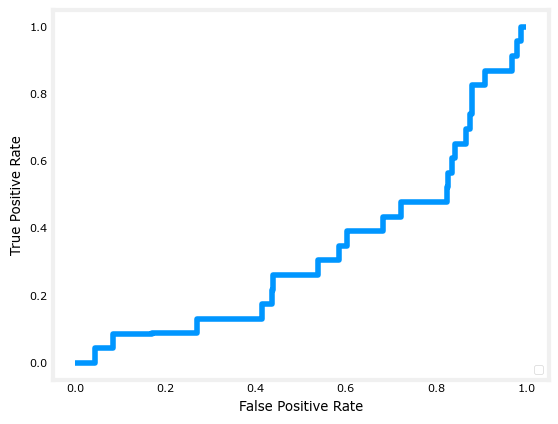

In [63]:
fpr, tpr, _ = roc_curve(model_truths, model_predictions)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

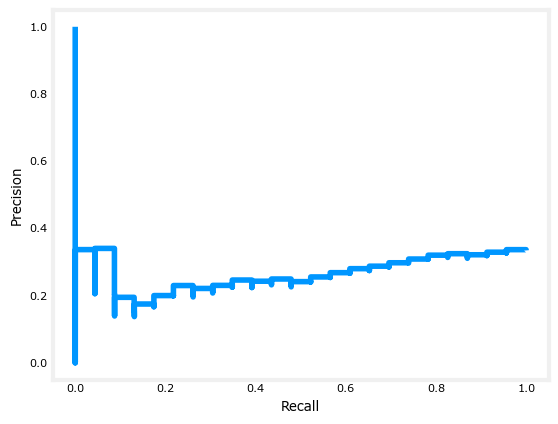

In [64]:
precision, recall, _ = precision_recall_curve(model_truths, model_predictions)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()